In [1]:
import sys
sys.path.append('..')
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

In [17]:
from common.trainer import Trainer
from common.optimizer import SGD
from common.util import preprocess, create_contexts_target, convert_one_hot
from common.functions import softmax, cross_entropy_error

In [18]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [tf.Variable(tf.zeros_like(W))]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        x = tf.dtypes.cast(x, dtype='float')
        out = tf.matmul(x, W)
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = tf.matmul(dout, tf.transpose(W))
        dW = tf.matmul(tf.transpose(self.x), dout)
        self.grads[0].assign(dW)
        return dx

In [19]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        x = tf.dtypes.cast(x, dtype='float')
        self.y = softmax(x)
        self.num_label = self.y.shape[1]
        if self.t.ndim == 1:
            self.t = tf.one_hot(self.t, num_label)
        
        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        t = self.t
        if t.ndim == 1:
            t = tf.one_hot(t, self.num_label)
        t = tf.dtypes.cast(t, dtype='float')

        dx = self.y
        dx_ones = tf.ones_like(self.y) * t
        dx -= dx_ones
        dx *= dout
        dx = dx / batch_size
        return dx

In [20]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = tf.Variable(tf.random.normal((V, H), mean=0.0, stddev=0.01, dtype='float'))
        W_out = tf.Variable(tf.random.normal((H, V), mean=0.0, stddev=0.01, dtype='float'))

        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [
                self.in_layer0,
                self.in_layer1,
                self.out_layer,
                self.loss_layer
        ]

        self.params = []
        self.grads = []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        
        return None

In [21]:

def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


In [22]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = tf.random.shuffle(tf.range(data_size))
            x = x[idx.numpy()]
            t = t[idx.numpy()]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
#                 params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
#                 if max_grad is not None:
#                     clip_grads(grads, max_grad)
                optimizer.update(model.params, model.grads)
                total_loss += loss
                loss_count += 1
                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()



In [23]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(tf.Variable(tf.zeros_like(param)))
                self.v.append(tf.Variable(tf.zeros_like(param)))
        
        self.iter += 1
        lr_t = self.lr * tf.math.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i].assign(self.m[i] + (1 - self.beta1) * (grads[i] - self.m[i]))
            self.v[i].assign(self.v[i] + (1 - self.beta2) * (grads[i]**2 - self.v[i]))
            
            params[i].assign(params[i] - lr_t * self.m[i] / (tf.math.sqrt(self.v[i]) + 1e-7))

In [24]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'you say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [25]:
trainer.fit(contexts, target, max_epoch, batch_size)


| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 195 |  iter 1 / 2 | time 1[s] | loss 1.02
| epoch 196 |  iter 1 / 2 | time 1[s] | loss 1.24
| epoch 197 |  iter 1 / 2 | time 1[s] | loss 1.18
| epoch 198 |  iter 1 / 2 | time 1[s] | loss 1.02
| epoch 199 |  iter 1 / 2 | time 1[s] | loss 1.17
| epoch 200 |  iter 1 / 2 | time 1[s] | loss 1.23
| epoch 201 |  iter 1 / 2 | time 1[s] | loss 0.99
| epoch 202 |  iter 1 / 2 | time 1[s] | loss 1.22
| epoch 203 |  iter 1 / 2 | time 1[s] | loss 1.08
| epoch 204 |  iter 1 / 2 | time 1[s] | loss 1.11
| epoch 205 |  iter 1 / 2 | time 1[s] | loss 1.21
| epoch 206 |  iter 1 / 2 | time 1[s] | loss 1.03
| epoch 207 |  iter 1 / 2 | time 1[s] | loss 1.20
| epoch 208 |  iter 1 / 2 | time 1[s] | loss 0.99
| epoch 209 |  iter 1 / 2 | time 1[s] | loss 1.10
| epoch 210 |  iter 1 / 2 | time 1[s] | loss 1.19
| epoch 211 |  iter 1 / 2 | time 1[s] | loss 1.06
| epoch 212 |  iter 1 / 2 | time 1[s] | loss 1.14
| epoch 213 |  iter 1 / 2 | time 1[s] | loss 1.06
| epoch 214 |  iter 1 / 2 | time 1[s] | loss 1.09


| epoch 388 |  iter 1 / 2 | time 2[s] | loss 0.77
| epoch 389 |  iter 1 / 2 | time 2[s] | loss 0.79
| epoch 390 |  iter 1 / 2 | time 2[s] | loss 0.99
| epoch 391 |  iter 1 / 2 | time 2[s] | loss 0.84
| epoch 392 |  iter 1 / 2 | time 2[s] | loss 0.83
| epoch 393 |  iter 1 / 2 | time 2[s] | loss 0.79
| epoch 394 |  iter 1 / 2 | time 2[s] | loss 0.81
| epoch 395 |  iter 1 / 2 | time 2[s] | loss 0.87
| epoch 396 |  iter 1 / 2 | time 2[s] | loss 0.89
| epoch 397 |  iter 1 / 2 | time 2[s] | loss 0.74
| epoch 398 |  iter 1 / 2 | time 2[s] | loss 0.84
| epoch 399 |  iter 1 / 2 | time 2[s] | loss 0.87
| epoch 400 |  iter 1 / 2 | time 2[s] | loss 0.88
| epoch 401 |  iter 1 / 2 | time 2[s] | loss 0.72
| epoch 402 |  iter 1 / 2 | time 2[s] | loss 0.89
| epoch 403 |  iter 1 / 2 | time 2[s] | loss 0.83
| epoch 404 |  iter 1 / 2 | time 2[s] | loss 0.83
| epoch 405 |  iter 1 / 2 | time 2[s] | loss 0.86
| epoch 406 |  iter 1 / 2 | time 2[s] | loss 0.80
| epoch 407 |  iter 1 / 2 | time 2[s] | loss 0.83


| epoch 553 |  iter 1 / 2 | time 3[s] | loss 0.71
| epoch 554 |  iter 1 / 2 | time 3[s] | loss 0.61
| epoch 555 |  iter 1 / 2 | time 3[s] | loss 0.80
| epoch 556 |  iter 1 / 2 | time 3[s] | loss 0.70
| epoch 557 |  iter 1 / 2 | time 3[s] | loss 0.61
| epoch 558 |  iter 1 / 2 | time 3[s] | loss 0.70
| epoch 559 |  iter 1 / 2 | time 3[s] | loss 0.85
| epoch 560 |  iter 1 / 2 | time 3[s] | loss 0.59
| epoch 561 |  iter 1 / 2 | time 3[s] | loss 0.76
| epoch 562 |  iter 1 / 2 | time 3[s] | loss 0.70
| epoch 563 |  iter 1 / 2 | time 3[s] | loss 0.64
| epoch 564 |  iter 1 / 2 | time 3[s] | loss 0.66
| epoch 565 |  iter 1 / 2 | time 3[s] | loss 0.85
| epoch 566 |  iter 1 / 2 | time 3[s] | loss 0.58
| epoch 567 |  iter 1 / 2 | time 3[s] | loss 0.75
| epoch 568 |  iter 1 / 2 | time 3[s] | loss 0.60
| epoch 569 |  iter 1 / 2 | time 3[s] | loss 0.79
| epoch 570 |  iter 1 / 2 | time 3[s] | loss 0.60
| epoch 571 |  iter 1 / 2 | time 3[s] | loss 0.69
| epoch 572 |  iter 1 / 2 | time 3[s] | loss 0.79


| epoch 745 |  iter 1 / 2 | time 4[s] | loss 0.55
| epoch 746 |  iter 1 / 2 | time 4[s] | loss 0.58
| epoch 747 |  iter 1 / 2 | time 4[s] | loss 0.52
| epoch 748 |  iter 1 / 2 | time 4[s] | loss 0.67
| epoch 749 |  iter 1 / 2 | time 4[s] | loss 0.52
| epoch 750 |  iter 1 / 2 | time 4[s] | loss 0.64
| epoch 751 |  iter 1 / 2 | time 4[s] | loss 0.49
| epoch 752 |  iter 1 / 2 | time 4[s] | loss 0.69
| epoch 753 |  iter 1 / 2 | time 4[s] | loss 0.55
| epoch 754 |  iter 1 / 2 | time 4[s] | loss 0.48
| epoch 755 |  iter 1 / 2 | time 4[s] | loss 0.60
| epoch 756 |  iter 1 / 2 | time 4[s] | loss 0.60
| epoch 757 |  iter 1 / 2 | time 4[s] | loss 0.59
| epoch 758 |  iter 1 / 2 | time 4[s] | loss 0.53
| epoch 759 |  iter 1 / 2 | time 4[s] | loss 0.61
| epoch 760 |  iter 1 / 2 | time 4[s] | loss 0.62
| epoch 761 |  iter 1 / 2 | time 4[s] | loss 0.57
| epoch 762 |  iter 1 / 2 | time 4[s] | loss 0.54
| epoch 763 |  iter 1 / 2 | time 4[s] | loss 0.60
| epoch 764 |  iter 1 / 2 | time 4[s] | loss 0.48


| epoch 932 |  iter 1 / 2 | time 5[s] | loss 0.46
| epoch 933 |  iter 1 / 2 | time 5[s] | loss 0.39
| epoch 934 |  iter 1 / 2 | time 5[s] | loss 0.51
| epoch 935 |  iter 1 / 2 | time 5[s] | loss 0.51
| epoch 936 |  iter 1 / 2 | time 5[s] | loss 0.38
| epoch 937 |  iter 1 / 2 | time 5[s] | loss 0.44
| epoch 938 |  iter 1 / 2 | time 5[s] | loss 0.55
| epoch 939 |  iter 1 / 2 | time 5[s] | loss 0.46
| epoch 940 |  iter 1 / 2 | time 6[s] | loss 0.38
| epoch 941 |  iter 1 / 2 | time 6[s] | loss 0.47
| epoch 942 |  iter 1 / 2 | time 6[s] | loss 0.45
| epoch 943 |  iter 1 / 2 | time 6[s] | loss 0.52
| epoch 944 |  iter 1 / 2 | time 6[s] | loss 0.43
| epoch 945 |  iter 1 / 2 | time 6[s] | loss 0.51
| epoch 946 |  iter 1 / 2 | time 6[s] | loss 0.46
| epoch 947 |  iter 1 / 2 | time 6[s] | loss 0.40
| epoch 948 |  iter 1 / 2 | time 6[s] | loss 0.51
| epoch 949 |  iter 1 / 2 | time 6[s] | loss 0.53
| epoch 950 |  iter 1 / 2 | time 6[s] | loss 0.29
| epoch 951 |  iter 1 / 2 | time 6[s] | loss 0.46


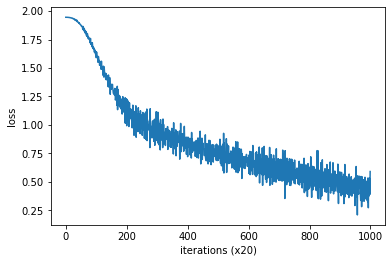

In [26]:
trainer.plot()

In [114]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id].numpy())

you [-0.7559733   0.8223706   1.7595266   0.82428426 -0.7417107 ]
say [ 1.6673946   0.28585762  0.36691344 -1.7274151   1.9685572 ]
goodbye [-1.5696769  1.6188371 -0.135139   1.7321404 -1.6519831]
and [ 1.1827497  2.315946   2.0437524 -1.4595901  1.1504059]
i [-1.5603639   1.6266162  -0.12618488  1.7150255  -1.6352584 ]
hello [-0.7619438   0.83408046  1.7539667   0.8280696  -0.7422945 ]
. [ 1.2357583 -1.3172857 -1.4190314 -1.0886376  1.2045853]


In [27]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = tf.Variable(tf.random.normal((V, H), mean=0.0, stddev=0.01, dtype='float'))
        W_out = tf.Variable(tf.random.normal((H, V), mean=0.0, stddev=0.01, dtype='float'))

        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        layers = [
                self.in_layer,
                self.out_layer,
                self.loss_layer1,
                self.loss_layer2
        ]

        self.params = []
        self.grads = []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        

        
        return None


In [28]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 10000

text = 'you say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [29]:
trainer.fit(contexts, target, max_epoch, batch_size)


| epoch 1 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 21 |  iter 1 / 2 | ti

| epoch 194 |  iter 1 / 2 | time 1[s] | loss 2.82
| epoch 195 |  iter 1 / 2 | time 1[s] | loss 2.86
| epoch 196 |  iter 1 / 2 | time 1[s] | loss 2.79
| epoch 197 |  iter 1 / 2 | time 1[s] | loss 2.87
| epoch 198 |  iter 1 / 2 | time 1[s] | loss 2.60
| epoch 199 |  iter 1 / 2 | time 1[s] | loss 2.87
| epoch 200 |  iter 1 / 2 | time 1[s] | loss 2.74
| epoch 201 |  iter 1 / 2 | time 1[s] | loss 2.75
| epoch 202 |  iter 1 / 2 | time 1[s] | loss 2.76
| epoch 203 |  iter 1 / 2 | time 1[s] | loss 2.86
| epoch 204 |  iter 1 / 2 | time 1[s] | loss 2.65
| epoch 205 |  iter 1 / 2 | time 1[s] | loss 2.78
| epoch 206 |  iter 1 / 2 | time 1[s] | loss 2.62
| epoch 207 |  iter 1 / 2 | time 1[s] | loss 2.92
| epoch 208 |  iter 1 / 2 | time 1[s] | loss 2.52
| epoch 209 |  iter 1 / 2 | time 1[s] | loss 2.86
| epoch 210 |  iter 1 / 2 | time 1[s] | loss 2.70
| epoch 211 |  iter 1 / 2 | time 1[s] | loss 2.81
| epoch 212 |  iter 1 / 2 | time 1[s] | loss 2.61
| epoch 213 |  iter 1 / 2 | time 1[s] | loss 2.81


| epoch 382 |  iter 1 / 2 | time 2[s] | loss 2.34
| epoch 383 |  iter 1 / 2 | time 2[s] | loss 2.42
| epoch 384 |  iter 1 / 2 | time 2[s] | loss 2.52
| epoch 385 |  iter 1 / 2 | time 2[s] | loss 2.05
| epoch 386 |  iter 1 / 2 | time 2[s] | loss 2.44
| epoch 387 |  iter 1 / 2 | time 2[s] | loss 2.46
| epoch 388 |  iter 1 / 2 | time 2[s] | loss 2.37
| epoch 389 |  iter 1 / 2 | time 2[s] | loss 2.41
| epoch 390 |  iter 1 / 2 | time 2[s] | loss 2.33
| epoch 391 |  iter 1 / 2 | time 2[s] | loss 2.41
| epoch 392 |  iter 1 / 2 | time 2[s] | loss 2.26
| epoch 393 |  iter 1 / 2 | time 2[s] | loss 2.62
| epoch 394 |  iter 1 / 2 | time 2[s] | loss 2.11
| epoch 395 |  iter 1 / 2 | time 2[s] | loss 2.47
| epoch 396 |  iter 1 / 2 | time 2[s] | loss 2.37
| epoch 397 |  iter 1 / 2 | time 2[s] | loss 2.26
| epoch 398 |  iter 1 / 2 | time 2[s] | loss 2.55
| epoch 399 |  iter 1 / 2 | time 2[s] | loss 2.05
| epoch 400 |  iter 1 / 2 | time 2[s] | loss 2.59
| epoch 401 |  iter 1 / 2 | time 2[s] | loss 2.43


| epoch 566 |  iter 1 / 2 | time 3[s] | loss 1.80
| epoch 567 |  iter 1 / 2 | time 3[s] | loss 2.37
| epoch 568 |  iter 1 / 2 | time 3[s] | loss 2.16
| epoch 569 |  iter 1 / 2 | time 3[s] | loss 2.23
| epoch 570 |  iter 1 / 2 | time 3[s] | loss 2.10
| epoch 571 |  iter 1 / 2 | time 3[s] | loss 2.30
| epoch 572 |  iter 1 / 2 | time 3[s] | loss 1.94
| epoch 573 |  iter 1 / 2 | time 3[s] | loss 2.21
| epoch 574 |  iter 1 / 2 | time 3[s] | loss 2.31
| epoch 575 |  iter 1 / 2 | time 3[s] | loss 1.85
| epoch 576 |  iter 1 / 2 | time 3[s] | loss 2.37
| epoch 577 |  iter 1 / 2 | time 3[s] | loss 2.15
| epoch 578 |  iter 1 / 2 | time 3[s] | loss 1.87
| epoch 579 |  iter 1 / 2 | time 3[s] | loss 2.30
| epoch 580 |  iter 1 / 2 | time 3[s] | loss 2.36
| epoch 581 |  iter 1 / 2 | time 3[s] | loss 1.93
| epoch 582 |  iter 1 / 2 | time 3[s] | loss 2.14
| epoch 583 |  iter 1 / 2 | time 3[s] | loss 2.05
| epoch 584 |  iter 1 / 2 | time 3[s] | loss 2.45
| epoch 585 |  iter 1 / 2 | time 3[s] | loss 1.98


| epoch 754 |  iter 1 / 2 | time 4[s] | loss 1.96
| epoch 755 |  iter 1 / 2 | time 4[s] | loss 2.19
| epoch 756 |  iter 1 / 2 | time 4[s] | loss 2.01
| epoch 757 |  iter 1 / 2 | time 4[s] | loss 1.96
| epoch 758 |  iter 1 / 2 | time 4[s] | loss 2.01
| epoch 759 |  iter 1 / 2 | time 4[s] | loss 1.98
| epoch 760 |  iter 1 / 2 | time 4[s] | loss 1.98
| epoch 761 |  iter 1 / 2 | time 4[s] | loss 1.78
| epoch 762 |  iter 1 / 2 | time 4[s] | loss 2.17
| epoch 763 |  iter 1 / 2 | time 4[s] | loss 2.01
| epoch 764 |  iter 1 / 2 | time 4[s] | loss 1.93
| epoch 765 |  iter 1 / 2 | time 4[s] | loss 1.98
| epoch 766 |  iter 1 / 2 | time 4[s] | loss 1.98
| epoch 767 |  iter 1 / 2 | time 4[s] | loss 2.00
| epoch 768 |  iter 1 / 2 | time 4[s] | loss 2.18
| epoch 769 |  iter 1 / 2 | time 4[s] | loss 2.00
| epoch 770 |  iter 1 / 2 | time 4[s] | loss 1.97
| epoch 771 |  iter 1 / 2 | time 4[s] | loss 1.98
| epoch 772 |  iter 1 / 2 | time 4[s] | loss 1.74
| epoch 773 |  iter 1 / 2 | time 4[s] | loss 1.98


| epoch 932 |  iter 1 / 2 | time 5[s] | loss 1.70
| epoch 933 |  iter 1 / 2 | time 5[s] | loss 2.35
| epoch 934 |  iter 1 / 2 | time 5[s] | loss 1.91
| epoch 935 |  iter 1 / 2 | time 5[s] | loss 1.69
| epoch 936 |  iter 1 / 2 | time 5[s] | loss 1.91
| epoch 937 |  iter 1 / 2 | time 5[s] | loss 2.13
| epoch 938 |  iter 1 / 2 | time 5[s] | loss 1.48
| epoch 939 |  iter 1 / 2 | time 5[s] | loss 2.14
| epoch 940 |  iter 1 / 2 | time 5[s] | loss 1.90
| epoch 941 |  iter 1 / 2 | time 5[s] | loss 1.91
| epoch 942 |  iter 1 / 2 | time 5[s] | loss 1.93
| epoch 943 |  iter 1 / 2 | time 5[s] | loss 1.91
| epoch 944 |  iter 1 / 2 | time 5[s] | loss 1.90
| epoch 945 |  iter 1 / 2 | time 5[s] | loss 2.14
| epoch 946 |  iter 1 / 2 | time 5[s] | loss 1.47
| epoch 947 |  iter 1 / 2 | time 5[s] | loss 2.34
| epoch 948 |  iter 1 / 2 | time 5[s] | loss 1.69
| epoch 949 |  iter 1 / 2 | time 5[s] | loss 1.91
| epoch 950 |  iter 1 / 2 | time 5[s] | loss 1.91
| epoch 951 |  iter 1 / 2 | time 5[s] | loss 1.70


| epoch 1116 |  iter 1 / 2 | time 6[s] | loss 2.11
| epoch 1117 |  iter 1 / 2 | time 6[s] | loss 1.66
| epoch 1118 |  iter 1 / 2 | time 6[s] | loss 1.89
| epoch 1119 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1120 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1121 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1122 |  iter 1 / 2 | time 6[s] | loss 1.89
| epoch 1123 |  iter 1 / 2 | time 6[s] | loss 1.89
| epoch 1124 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1125 |  iter 1 / 2 | time 6[s] | loss 1.89
| epoch 1126 |  iter 1 / 2 | time 6[s] | loss 2.11
| epoch 1127 |  iter 1 / 2 | time 6[s] | loss 1.66
| epoch 1128 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1129 |  iter 1 / 2 | time 6[s] | loss 1.89
| epoch 1130 |  iter 1 / 2 | time 6[s] | loss 1.89
| epoch 1131 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1132 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1133 |  iter 1 / 2 | time 6[s] | loss 1.89
| epoch 1134 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1135 |  iter 1 / 2 | ti

| epoch 1302 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1303 |  iter 1 / 2 | time 7[s] | loss 2.10
| epoch 1304 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1305 |  iter 1 / 2 | time 7[s] | loss 1.41
| epoch 1306 |  iter 1 / 2 | time 7[s] | loss 2.10
| epoch 1307 |  iter 1 / 2 | time 7[s] | loss 2.10
| epoch 1308 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1309 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1310 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1311 |  iter 1 / 2 | time 7[s] | loss 1.64
| epoch 1312 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1313 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1314 |  iter 1 / 2 | time 7[s] | loss 1.65
| epoch 1315 |  iter 1 / 2 | time 7[s] | loss 2.33
| epoch 1316 |  iter 1 / 2 | time 7[s] | loss 1.64
| epoch 1317 |  iter 1 / 2 | time 7[s] | loss 2.10
| epoch 1318 |  iter 1 / 2 | time 7[s] | loss 1.65
| epoch 1319 |  iter 1 / 2 | time 7[s] | loss 2.09
| epoch 1320 |  iter 1 / 2 | time 7[s] | loss 1.64
| epoch 1321 |  iter 1 / 2 | ti

| epoch 1486 |  iter 1 / 2 | time 8[s] | loss 2.09
| epoch 1487 |  iter 1 / 2 | time 8[s] | loss 1.87
| epoch 1488 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1489 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1490 |  iter 1 / 2 | time 8[s] | loss 2.09
| epoch 1491 |  iter 1 / 2 | time 8[s] | loss 1.63
| epoch 1492 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1493 |  iter 1 / 2 | time 8[s] | loss 2.09
| epoch 1494 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1495 |  iter 1 / 2 | time 8[s] | loss 1.64
| epoch 1496 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1497 |  iter 1 / 2 | time 8[s] | loss 1.87
| epoch 1498 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1499 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1500 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1501 |  iter 1 / 2 | time 8[s] | loss 1.63
| epoch 1502 |  iter 1 / 2 | time 8[s] | loss 2.32
| epoch 1503 |  iter 1 / 2 | time 8[s] | loss 1.63
| epoch 1504 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1505 |  iter 1 / 2 | ti

| epoch 1670 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1671 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1672 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1673 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1674 |  iter 1 / 2 | time 9[s] | loss 1.40
| epoch 1675 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1676 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1677 |  iter 1 / 2 | time 9[s] | loss 1.40
| epoch 1678 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1679 |  iter 1 / 2 | time 9[s] | loss 2.32
| epoch 1680 |  iter 1 / 2 | time 9[s] | loss 1.63
| epoch 1681 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1682 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1683 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1684 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1685 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1686 |  iter 1 / 2 | time 9[s] | loss 1.40
| epoch 1687 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1688 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1689 |  iter 1 / 2 | ti

KeyboardInterrupt: 

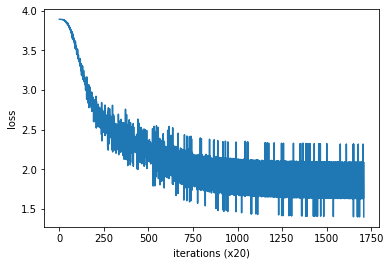

In [30]:
trainer.plot()

In [31]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id].numpy())

you [ 0.00994678  0.02152899  0.00336405  0.00933275 -0.00116532]
say [-0.17642404 -0.2962202  -1.7055287   1.1071124  -0.99272126]
goodbye [-1.4574679  0.7753694  0.921948  -0.8706593  0.7663139]
and [ 1.6370062  -1.4917974   0.20592137  1.2029492  -1.2744977 ]
i [-1.4552317   0.7734734   0.92338175 -0.8652832   0.76650774]
hello [ 1.2125714  1.0916641  1.0987887 -1.0466484  1.2186764]
. [-0.02028217  0.00351092  0.00466813  0.01408301 -0.00412838]
